# Importing

In [2]:
import pandas as pd
import numpy as np
import os

# data transform

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# models check
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# zapisywanie modeli
import joblib

# for load the data pre-preparation function
import importlib.util

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

import os

In [53]:
np.set_printoptions(suppress=False)

work_dir = r'C:\Users\User\Desktop\python-project-ApartmentPriceAnalysis'
os.chdir(work_dir)

pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# loading functions from the file
module_name = f"pipeline_pre-processing"
module_path = f"pipeline_pre-processing.py"

spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [5]:
data_initial = pd.read_csv('data_2024-01.csv', index_col = 0)

# Functions for processing data

### replace_mistakes_with_na

In [85]:
def replace_mistakes_with_na(data):
    
    """
    Cleans data by replacing obviously incorrect or implausible values in selected numerical columns with NaN.

    Specifically:
    - Replaces values in the 'area' column below 10 and above 500 with NaN,
      as these are likely due to data entry errors.
    - Replaces values above 100 in 'number_floor_in_building' and 'ap_floor' with NaN,
      as these are likely due to data entry errors.
    - Replaces values in the 'year' column below 1700 with NaN, assuming such years are invalid
      for apartment construction.

    Parameters:
    -----------
    data : pd.DataFrame
        The input dataset to be cleaned.

    Returns:
    --------
    data_clean : pd.DataFrame
        The cleaned dataset with incorrect values replaced by NaN.
    """

    # Create copy of the original dataset to avoid modifying it in-place
    data_clean = data.copy()
    
    # Set area information with area above 500 or below 10 to NaN
    data_clean['area'] = (
        data_clean['area']
        .apply(lambda x: x if pd.isna(x) or (x <= 500 and x >= 10) else np.nan)
    )
    data_clean['area'] = pd.to_numeric(data_clean['area'])

    # Set floor information with floor number above 100 to NaN
    data_clean['number_floor_in_building'] = (
        data_clean['number_floor_in_building']
        .apply(lambda x: x if pd.isna(x) or x <= 100 else np.nan)
    )
    data_clean['number_floor_in_building'] = pd.to_numeric(data_clean['number_floor_in_building'])

    data_clean['ap_floor'] = (
        data_clean['ap_floor']
        .apply(lambda x: x if pd.isna(x) or x <= 100 else np.nan)
    )
    data_clean['ap_floor'] = pd.to_numeric(data_clean['ap_floor'])

    # Set construction years below 1700 to NaN
    data_clean['year'] = (
        data_clean['year']
        .apply(lambda x: x if pd.isna(x) or x >= 1700 else np.nan)
    )
    data_clean['year'] = pd.to_numeric(data_clean['year']).astype('Int64')
    
    return data_clean

### clean_missing_values

In [86]:
def clean_missing_values(data, train_dataset, variables_to_drop_na):

    """
    Replaces specified outlier or rare category values in all columns of the dataset with a general label 'inny' (Polish for "other").

    Parameters:
    -----------
    data : pd.DataFrame
        The input dataset containing categorical variables.

    categories_to_replace : list of str
        A list of category values (strings) that should be considered outliers or rare,
        and replaced with the label 'inny' (Polish for "other").

    Returns:
    --------
    data_clean : pd.DataFrame
        A cleaned version of the input dataset with specified category values replaced by 'inny'.
    """
    
    # Create copy of the original dataset to avoid modifying it in-place
    data_clean_missing = data.copy()
    
    # Remove rows with NA values in the specified columns
    data_clean_missing = data_clean_missing.dropna(subset = variables_to_drop_na)
    
    # If this is test data, print a message about removed rows due to missing values
    if not train_dataset:
        if len(data) > len(data_clean_missing):
            print("""
                  W zbiorze wystąpiły braki w cechach: 'typ budynku', 'powierzchnia',
                  'liczba pokoi', 'rynek', 'ogłoszeniodawca', 'miasto', 'województwo'.
                  Do otrzymania prognozy wszystkie z powyższych cech
                  muszą być wypełnione.
                  Obserwacje te zostały usunięte ze zbioru do predykcji.
                  """)    
    
    return data_clean_missing

### proceed_outlier_categories

In [87]:
def proceed_outlier_categories(data, categories_to_replace):
    
    """
    Replaces outlier category values in the dataset with a general label 'inny'.

    Parameters:
    -----------
    data : pd.DataFrame
        The input dataset containing categorical variables.
    
    categories_to_replace : list
        A list of categories values
        that should be replaced with the label 'inny' (Polish for "other").

    Returns:
    --------
    data_clean : pd.DataFrame
        A cleaned version of the input dataset with specified category values replaced.
    """

    # Create copy of the original dataset to avoid modifying it in-place
    data_clean = data.copy()
    
    # Replace rare or inconsistent category values with 'inny' (Polish for "other")
    data_clean = data_clean.replace(categories_to_replace, 'inny')
    
    return data_clean

### proceed_outliers

In [88]:
def proceed_outliers(data, train_dataset,
                     minprice, maxprice,
                     minarea, maxarea,
                     maxfloor, minyear,
                     to_delete_from_test_set):
    
    """
    Filters out observations that are likely outliers based on provided thresholds 
    for selected numerical features such as price, area, floor level, and year of construction.

    Parameters:
    -----------
    data : pd.DataFrame
        The input dataset containing apartment listings.

    train_dataset : bool
        Indicates whether the data is used for training (True) or inference/prediction (False).

    minprice : float
        Minimum acceptable price. Listings with a lower price are considered outliers.

    maxprice : float
        Maximum acceptable price. Listings with a higher price are considered outliers.

    minarea : float
        Minimum acceptable area (m²). Listings with a smaller area are considered outliers.

    maxarea : float
        Maximum acceptable area (m²). Listings with a larger area are considered outliers.

    maxfloor : int
        Maximum acceptable floor level. Higher floor numbers are treated as outliers.

    minyear : int
        Minimum acceptable construction year. Years below this threshold are treated as invalid.
        
    to_delete_from_test_set : bool
        Indicates whether outlier observations will remain in the test set or be removed.
        
    Returns:
    --------
    pd.DataFrame
        Cleaned dataset with extreme values filtered out (if `train_dataset=True`) 
        or the original dataset with a warning printed about outliers (if `train_dataset=False`).
    """

    # Create copy of the original dataset to avoid modifying it in-place
    data_clean = data.copy()
    
    # Filter observations based on price range
    data_clean = data_clean[data_clean['price'] <= maxprice]
    data_clean = data_clean[data_clean['price'] >= minprice]
    
    # Filter observations based on area range
    data_clean = data_clean[
        (data_clean['area'] <= maxarea) |
        (data_clean['area'].isna())
    ]
    data_clean = data_clean[
        (data_clean['area'] >= minarea)|
        (data_clean['area'].isna())
    ]
    
    # Filter based on floor information (if not missing)
    data_clean = data_clean[
        (data_clean['number_floor_in_building'] <= maxfloor) | 
        (data_clean['number_floor_in_building'].isna())
    ]
    data_clean = data_clean[
        (data_clean['ap_floor'] <= maxfloor) |
        (data_clean['ap_floor'].isna())
    ]

    # Filter based on year of building information
    data_clean = data_clean[
        (data_clean['year'] >= minyear) |
        (data_clean['year'].isna())
    ]
    
    if train_dataset:
        # For training data, return only the cleaned records
        return data_clean
    else:
        # For inference data, return full data but warn about outliers
        if len(data) > (len(data_clean) + sum(data['price'].isna())):
            if not to_delete_from_test_set:
                print("""
                      W zbiorze wystąpiły obserwację o skrajnych wartościach
                      ze względu na zaproponowaną cenę, powierzchnię, piętro lub rok budynku.
                      Może zmniejszeć dokładność prognozy.
                      """)
                return data
            else:
                print("""
                      W zbiorze wystąpiły obserwację o skrajnych wartościach
                      ze względu na zaproponowaną cenę, powierzchnię, piętro lub rok budynku.
                      Obserwacje te zostały usunięte ze zbioru do predykcji.
                      """)
                return data_clean

### cleaning_data

In [89]:
def cleaning_data (data, train_dataset, to_delete_from_test_set = True):
    
    """
    Applies a sequence of data cleaning operations on a dataset, including:
    - Replacing clearly incorrect numerical values with missing values
    - Dropping observations with missing values in key variables
    - Replacing rare categorical values
    - Removing outliers based on defined thresholds

    Parameters:
    -----------
    data : pd.DataFrame
        The input dataset to be cleaned.

    train_dataset : bool
        Indicates whether the data is used for model training (True)
        or for inference/prediction (False). This affects how aggressively outliers and missing data are removed.
        
    to_delete_from_test_set : bool
        Indicates whether outlier observations will remain in the test set or be removed. Default is set to True.
        
    Returns:
    --------
    pd.DataFrame
        Cleaned dataset after all preprocessing steps.
    """
    
    # Load thresholds and rules for outlier and missing value handling from file
    outlier_values_dict = joblib.load("1. Data Preparation/outlier_values_dict.joblib")
    
    variables_to_drop_na = outlier_values_dict["variables_to_drop_na"]
    categories_to_replace = outlier_values_dict["categories_to_replace"]
    minprice = outlier_values_dict["min_price"]
    maxprice = outlier_values_dict["max_price"]
    minarea = outlier_values_dict["min_area"]
    maxarea = outlier_values_dict["max_area"]
    maxfloor = outlier_values_dict["max_floor"]
    minyear = outlier_values_dict["min_year"]
    
    # Replace implausible or erroneous numeric values with NaN
    replaced_mistakes_data = replace_mistakes_with_na(data)
    
    # Drop observations with missing values in critical variables
    cleaned_missind_values_data = clean_missing_values(replaced_mistakes_data, train_dataset, variables_to_drop_na)
    
    # Replace rare categorical values with a standard label
    proceeded_outlier_cat_data = proceed_outlier_categories(cleaned_missind_values_data, categories_to_replace)
    
    # Remove or flag outliers based on provided thresholds
    procceded_outliers_data = proceed_outliers(proceeded_outlier_cat_data,
                                               train_dataset,
                                               minprice, maxprice,
                                               minarea, maxarea,
                                               maxfloor, minyear,
                                               to_delete_from_test_set)
    
    return procceded_outliers_data

### one_hot_encode

In [90]:
def one_hot_encode_train_test(X_train_to_encode, X_test_to_encode, features_to_onehotencode):
    
    """
    One-hot encodes selected categorical features with category dropping for stability.
    
    Parameters:
    -----------
    X_train_to_encode : pd.DataFrame
        Training data.
    X_test_to_encode : pd.DataFrame
        Test data.
    features_to_onehotencode : list of str
        List of categorical feature names to be one-hot encoded.

    Returns:
    --------
    X_train : pd.DataFrame
        Training data with encoded features.
    X_test : pd.DataFrame
        Test data with encoded features.
    """
    
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_encode.copy()
    X_test = X_test_to_encode.copy()
    
    for column in features_to_onehotencode:
        # Define categories to drop if found
        categories_to_drop = ['nie podano', 'inny', 'wtórny', 'prywatny', 'opolskie']
        
        # Decide which category to drop fot this feature
        cat_to_drop = None
        for cat in categories_to_drop:
            if cat in X_train[column].unique():
                cat_to_drop = [cat]
                break
                
        # Create and fit the encoder
        encoder = OneHotEncoder(drop = cat_to_drop if cat_to_drop else 'first', sparse=False, handle_unknown='ignore')
        encoder.fit(X_train[[column]])
        
        # Column names for output
        cols = encoder.get_feature_names_out([column])
        
        # Transform both train and test
        X_train_encoded = pd.DataFrame(encoder.transform(X_train[[column]]), columns=cols, index=X_train.index)
        X_test_encoded = pd.DataFrame(encoder.transform(X_test[[column]]), columns=cols, index=X_test.index)
        
        # Join with original data
        X_train = pd.concat([X_train, X_train_encoded], axis=1)
        X_test = pd.concat([X_test, X_test_encoded], axis=1)
        
    # Drop the original categorical column
    X_train.drop(features_to_onehotencode, axis=1, inplace=True)
    X_test.drop(features_to_onehotencode, axis=1, inplace=True)
    
    return X_train, X_test

### scale

In [91]:
def scale_train_test(X_train_to_scale, X_test_to_scale):
    
    """
    Standardizes numerical features in training and test datasets using StandardScaler.

    This function applies z-score normalization to ensure each feature has a mean of 0
    and standard deviation of 1. It fits the scaler only on the training data and uses
    the same transformation on the test data to avoid data leakage.

    Parameters:
    -----------
    X_train_to_scale : pd.DataFrame
        The training dataset with numerical features to be standardized.

    X_test_to_scale : pd.DataFrame
        The test dataset with the same structure as X_train_to_scale.

    Returns:
    --------
    X_train : pd.DataFrame
        The standardized training dataset.

    X_test : pd.DataFrame
        The standardized test dataset, transformed using the scaler fitted on training data.
    """
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_scale.copy()
    X_test = X_test_to_scale.copy() 
    
    # Create and fit the scaler
    scaler = StandardScaler()

    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
        
    return X_train, X_test

### kNN_impute

In [92]:
def kNN_impute_train_test(X_train_to_impute, X_test_to_impute,
                          features_for_kNN_impute, features_to_onehotencode):       
    
    """
    Performs K-Nearest Neighbors (KNN) imputation on selected features in training and test datasets.

    This function uses the KNNImputer to fill in missing values in specified features by
    leveraging similarity between instances. It also automatically handles one-hot encoded
    categorical variables by including all derived columns in the imputation process.

    Parameters:
    -----------
    X_train_to_impute : pd.DataFrame
        Training dataset containing missing values to be imputed.

    X_test_to_impute : pd.DataFrame
        Test dataset with the same structure as the training data.

    features_for_kNN_impute : list of str
        List of original feature names to apply KNN imputation to.
        If a feature has been one-hot encoded, columns after encoding
        will be included in the imputation process.

    Returns:
    --------
    X_train : pd.DataFrame
        Training dataset with missing values imputed using KNN.

    X_test : pd.DataFrame
        Test dataset imputed using the same fitted KNN model from training data.
    """
    
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_impute.copy()
    X_test = X_test_to_impute.copy()
    features_for_kNN_impute_new = features_for_kNN_impute.copy()
    
    # Identify which features were one-hot encoded
    encoded_vars = list(set(features_for_kNN_impute) & set(features_to_onehotencode))
    
    # Replace original variable name with all derived one-hot encoded columns
    for var in encoded_vars:
        col_after_encode = [col for col in X_train.columns if col.startswith(var)]
        features_for_kNN_impute_new.remove(var)
        features_for_kNN_impute_new = features_for_kNN_impute_new + col_after_encode
        
    # Create the imputer
    imputer = KNNImputer()
    
    # Fit and apply KNN imputation to the selected columns
    X_train[features_for_kNN_impute_new] = imputer.fit_transform(X_train[features_for_kNN_impute_new])
    X_test[features_for_kNN_impute_new] = imputer.transform(X_test[features_for_kNN_impute_new])
    
    return X_train, X_test

### prepare_train_test_data

In [93]:
def prepare_train_test_data (data, to_delete_from_test_set, test_size, random_seed):
    
    """
    Prepares and processes the dataset for model training and evaluation by applying
    feature selection, encoding, scaling, and missing value imputation.

    The function loads preprocessing configuration from a saved dictionary and performs the following steps:
    1. Splits the dataset into train and test sets.
    2. Cleans missing and outlier values in train and test sets.
    3. Selects relevant features and target column.
    3. Applies one-hot encoding to categorical features.
    4. Scales numeric features using StandardScaler.
    5. Imputes missing values using K-Nearest Neighbors imputation.

    Parameters:
    -----------
    data : pd.DataFrame
        The full dataset to be prepared for training and testing.
    
    to_delete_from_test_set : bool
        Indicates whether outlier observations will remain in the test set or be removed. Default is set to True.

    test_size : float
        Proportion of the dataset to include in the test split (e.g., 0.2 for 20%).

    random_seed : int
        Random seed to ensure reproducibility of the train-test split.

    Returns:
    --------
    X_train_imputed : pd.DataFrame
        Fully preprocessed training feature set.

    X_test_imputed : pd.DataFrame
        Fully preprocessed test feature set.

    y_train : pd.Series
        Target variable for training data.

    y_test : pd.Series
        Target variable for test data.
    """
    
    # Load preprocessing configuration with selected features and target definition
    model_features_dict = joblib.load("1. Data Preparation/model_features_dict.joblib")
    
    features_to_use = model_features_dict['features_to_use']
    target = model_features_dict['target']
    features_to_onehotencode = model_features_dict['features_to_onehotencode']
    features_for_kNN_impute = model_features_dict['features_for_kNN_impute']
    
    # Validate that all required features exist in the provided dataset
    if all(x in data.columns for x in model_features_dict['features_to_use']) == 0:
        print("The dataset does not have all the variables defined for modeling")
    
    # Split the dataset into training and testing sets
    train_data, test_data = train_test_split(data,
                                             test_size = test_size,
                                             random_state = random_seed)

    # Clean the train and test data
    train_cleaned_data = cleaning_data(train_data, train_dataset = True)
    
    test_cleaned_data = cleaning_data(test_data,
                                      train_dataset = False,
                                      to_delete_from_test_set = to_delete_from_test_set)
    
    # Since the test set is needed for the evaluation of the model, it must not contain missing data in the target variable
    test_cleaned_data = test_cleaned_data.dropna(subset = target)

    # Extract features (X) and target variable (y)
    X_train = train_cleaned_data[features_to_use]
    y_train = train_cleaned_data[target]

    X_test = test_cleaned_data[features_to_use]
    y_test = test_cleaned_data[target]
    
    # Ensure NaNs are np.nan, not pd.NA
    X_train = X_train.replace({pd.NA: np.nan})
    X_test = X_test.replace({pd.NA: np.nan})
    
    # One-hot encode categorical features
    X_train_encoded, X_test_encoded = one_hot_encode_train_test(X_train, X_test, features_to_onehotencode)
    
    # Scale features using StandardScaler
    X_train_scaled, X_test_scaled = scale_train_test(X_train_encoded, X_test_encoded)
    
    # Impute missing values using KNN imputer
    X_train_imputed, X_test_imputed = kNN_impute_train_test(X_train_scaled, X_test_scaled,
                                                            features_for_kNN_impute, features_to_onehotencode)
    
    return X_train_imputed, X_test_imputed, y_train, y_test

# Data preparation

In [15]:
data_for_analysis = module.preliminary_transform(data_initial, True)

All the categorizations occurring in the set in multi-vector selection variables were coded.


In [113]:
(X_train,
 X_test_without_outliers,
 y_train,
 y_test_without_outliers) = prepare_train_test_data(data_for_analysis,
                                                    to_delete_from_test_set = True,
                                                    test_size = 0.2, random_seed = 99)

(X_train,
 X_test_with_outliers,
 y_train,
 y_test_with_outliers) = prepare_train_test_data(data_for_analysis,
                                                 to_delete_from_test_set = False,
                                                 test_size = 0.2, random_seed = 99)

modeling_data = {'X_train': X_train,
                 'y_train': y_train,
                 'X_test_without_outliers': X_test_without_outliers,
                 'y_test_without_outliers': y_test_without_outliers,
                 'X_test_with_outliers': X_test_with_outliers,
                 'y_test_with_outliers': y_test_with_outliers}



                  W zbiorze wystąpiły braki w cechach: 'typ budynku', 'powierzchnia',
                  'liczba pokoi', 'rynek', 'ogłoszeniodawca', 'miasto', 'województwo'.
                  Do otrzymania prognozy wszystkie z powyższych cech
                  muszą być wypełnione.
                  Obserwacje te zostały usunięte ze zbioru do predykcji.
                  

                      W zbiorze wystąpiły obserwację o skrajnych wartościach
                      ze względu na zaproponowaną cenę, powierzchnię, piętro lub rok budynku.
                      Obserwacje te zostały usunięte ze zbioru do predykcji.
                      

                  W zbiorze wystąpiły braki w cechach: 'typ budynku', 'powierzchnia',
                  'liczba pokoi', 'rynek', 'ogłoszeniodawca', 'miasto', 'województwo'.
                  Do otrzymania prognozy wszystkie z powyższych cech
                  muszą być wypełnione.
                  Obserwacje te zostały usunięte ze zbioru do predykcj

# Functions for modeling

### model_summary

In [172]:
def model_summary(regressor, title, modeling_data):
    
    X_test_without_outliers = modeling_data['X_test_without_outliers']
    y_test_without_outliers = modeling_data['y_test_without_outliers']
    
    X_test_with_outliers = modeling_data['X_test_with_outliers']
    y_test_with_outliers = modeling_data['y_test_with_outliers']

    list_of_data = [[X_test_without_outliers, y_test_without_outliers],
                    [X_test_with_outliers, y_test_with_outliers]]
    
    fig, ax = plt.subplots(2, 1, figsize=(11, 7))
    
    for i in range(2):
        
        X_test = list_of_data[i][0]
        y_test = list_of_data[i][1]
    
        prediction = regressor.predict(X_test)
        
        

        rmse = round(np.sqrt(metrics.mean_squared_error(y_test, prediction)),2)
        r2 = round(metrics.r2_score(y_test, prediction),3)
        n = len(y_test)  # number of observations
        p = len(X_test.columns)  # number of predictors
        adjusted_r2 = round(1 - (1 - r2) * (n - 1) / (n - p - 1),3)
        
        
        
        sns.scatterplot(x = y_test, y = prediction, alpha = 0.4, ax = ax[i])
        ax[i].set_title(title)
        ax[i].set_xlabel("Actual")
        ax[i].set_ylabel("Predict")
        x_lim_max = ax[i].get_xlim()[1]
        y_lim_max = ax[i].get_ylim()[1]
        ax[i].text(x_lim_max**0.75,
                   y_lim_max*0.75,
                   f'Wskaźniki:\nRMSE:{"{:,}".format(rmse)} zł\nR^2:{r2}\nAdj.R^2:{adjusted_r2}')
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.87, 
                        wspace=0.15, 
                        hspace=0.45)
    
    plt.show()

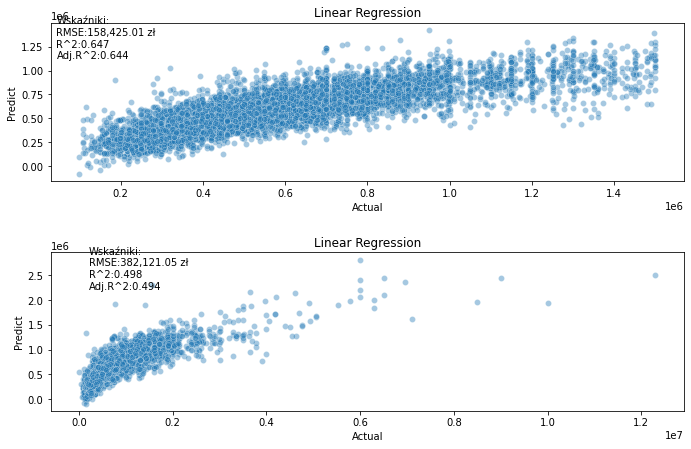

In [173]:
X_train = modeling_data['X_train']
y_train = modeling_data['y_train']

linear = LinearRegression(n_jobs=-2)
linear.fit(X_train, y_train)

model_summary(linear, "Linear Regression", modeling_data)

### model_selection

In [127]:
def model_selection (regressor, param_grid):
    
    # Załądowanie danych trainingowych
    X_train = modeling_data['X_train']
    y_train = modeling_data['y_train']
    X_test = modeling_data['X_test_without_outliers']
    y_test = modeling_data['y_test_without_outliers']

    # Inicjacja Grid Search z cross-validation
    rf_grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5,
                                          scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

    # Dopasowanie Grid Search do danych treningowych
    rf_grid_search.fit(X_train, y_train)

    # Wybór najlepszego modelu
    best_model = rf_grid_search.best_estimator_

    # Ocena modelu na danych trenongowych
    train_score = best_model.score(X_train, y_train)
    print("Train Score:", train_score)

    # Ocena modelu na best_rf_model_primary testowych
    test_score = best_model.score(X_test, y_test)
    print("Test Score:", test_score)

    # Wyświetlenie najlepszych parametrów
    print("Najlepsze parametry:", rf_grid_search.best_params_)
        
    return best_model

# Choosing models

## Random Forest

In [130]:
# Definicja modelu Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)

# Definicja siatki parametrów do przeszukania
param_grid_rf = {
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5, 10],
    'max_features': [16, 32, 48],
    'max_depth': [30, 40, 50]
}

best_rf_model = model_selection(rf_regressor, param_grid_rf)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Train Score: 0.9754952073106236
Test Score: 0.8260234446413003
Najlepsze parametry: {'max_depth': 50, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}


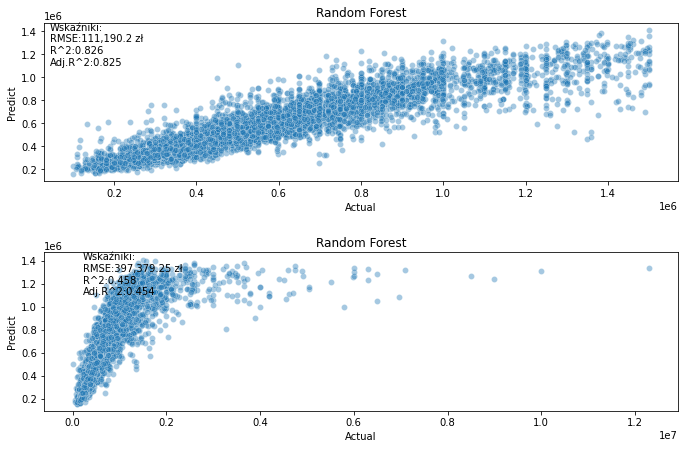

In [174]:
model_summary(best_rf_model, "Random Forest", modeling_data)

## XGBoost

In [131]:
xgboost_regressor = GradientBoostingRegressor(random_state=42, n_estimators=100)

# Definicja siatki parametrów do przeszukania
param_grid_xgboost = {
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'subsample': [0.33, 0.5],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': [32, 48, 64],
    'max_depth': [30, 40, 50, 60]
}

best_xgboost_model = model_selection(xgboost_regressor, param_grid_xgboost)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train Score: 0.9984828405568079
Test Score: 0.8377101974777276
Najlepsze parametry: {'learning_rate': 0.05, 'max_depth': 30, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 0.5}


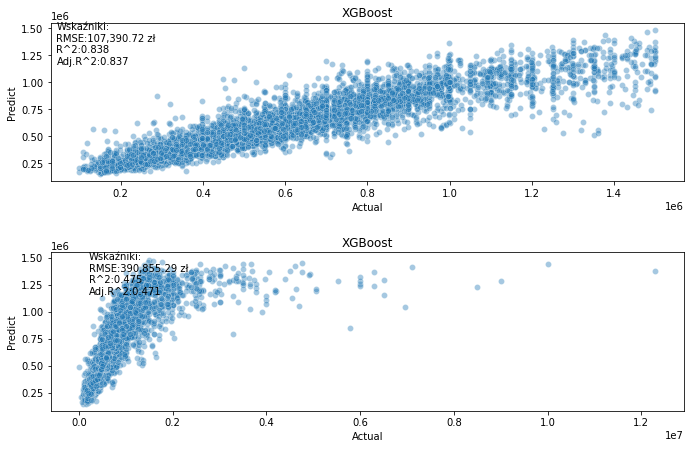

In [175]:
model_summary(best_xgboost_model, "XGBoost", modeling_data)

## KNNRegressor

In [132]:
# Definicja modelu Random Forest Regressor
knn_regressor = KNeighborsRegressor()

# Definicja siatki parametrów do przeszukania
param_grid_knn = {
    'n_neighbors': [5, 10, 20, 30, 50],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': [30, 50, 100, 200],
    'p': [1, 2]
}

best_knn_model = model_selection(knn_regressor, param_grid_knn)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Train Score: 0.9999038611308105
Test Score: 0.6863256255538606
Najlepsze parametry: {'algorithm': 'ball_tree', 'leaf_size': 100, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


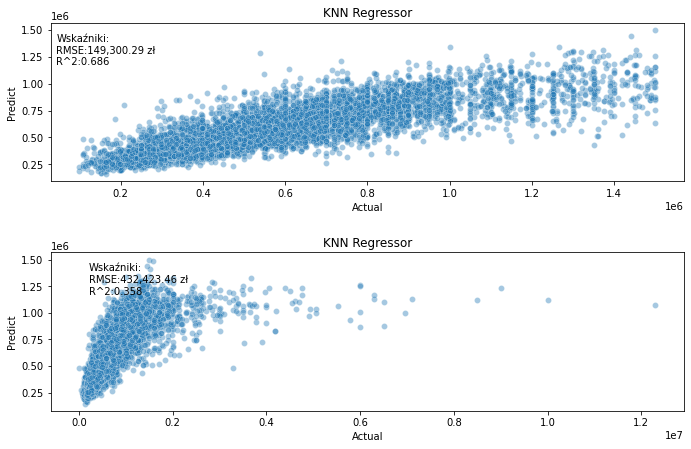

In [170]:
model_summary(best_knn_model, "KNN Regressor", modeling_data)

## MLPRegressor

In [ ]:
# Definicja modelu Random MLPRegressor
mlp_regressor = MLPRegressor(max_iter = 100, learning_rate = 'constant',
                             early_stopping = True, random_state = 99)

# Definicja siatki parametrów do przeszukania
param_grid_mlp = {
    'hidden_layer_sizes': [(200,2), (150,2), (150,1), (100,2), (25,2)],
    'learning_rate_init': [0.05, 0.1, 0.15],
    'n_iter_no_change': [2, 5]
}

best_mlp_model = model_selection(mlp_regressor, param_grid_mlp)

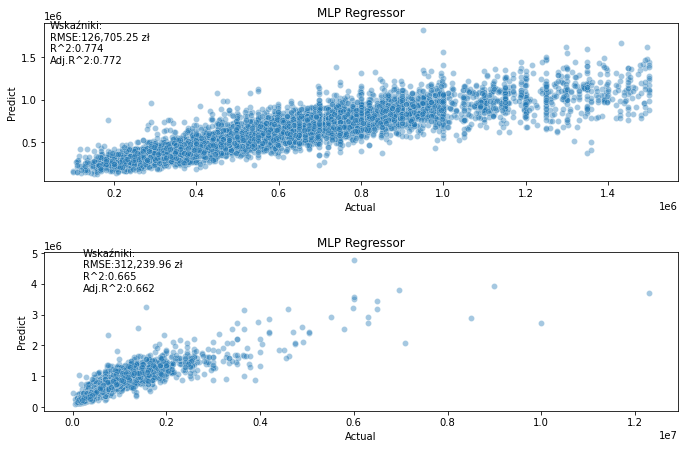

In [176]:
model_summary(best_mlp_model, "MLP Regressor", modeling_data)